In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = False

In [3]:
import consultas as cst

In [4]:
from datetime import datetime, timedelta
import winsound

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
import pickle

In [6]:
#periodo
periodo = 202201

In [7]:
query = f'''
SELECT /*+PARALLEL(8)*/ 
    *
FROM AGG_DL_PJ_QUALITY
WHERE PERIODO_PROCESO_CODIGO = {periodo}
'''

df = cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [8]:
pd.DataFrame(df['PREDICCION'].value_counts()/len(df)*100)

,PREDICCION
0,70.62928
1,29.37072


In [10]:
query = f'''
SELECT /*+PARALLEL(8)*/ 
    A.SUBSCRIBER_ID,
    A.FECHA_ALTA,
    A.FECHA_ALTA + 8 AS FECHA_PRED,
    COALESCE(A.OPERADOR_PORTA_ORIGEN, 'LINEA_NUEVA') AS OPERADOR_ORIGEN,
    B.PERIODO_PROCESO_CODIGO AS ULT_MES,
    B.MOVIMIENTO_TIPO_NOMBRE AS ULT_MOV,
    B.FECHA_BAJA,
    A.CONSULTOR_DK,
    B.ESTADO,
    C.CONSULTOR_CANAL_NOMBRE, 
    C.CONSULTOR_SUBCANAL_NOMBRE, 
    C.CONSULTOR_ALMACEN_NOMBRE, 
    C.CONSULTOR_NOMBRE_NIVEL_8,
    B.RN
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
LEFT JOIN (
    SELECT /*+PARALLEL(8)*/ 
        SUBSCRIBER_ID,
        PERIODO_PROCESO_CODIGO,
        MOVIMIENTO_TIPO_NOMBRE,
        FECHA_BAJA,
        ESTADO,
        RN
    FROM (
        SELECT /*+PARALLEL(8)*/
            SUBSCRIBER_ID,
            PERIODO_PROCESO_CODIGO,
            MOVIMIENTO_TIPO_NOMBRE,
            FECHA_BAJA,
            ESTADO,
            ROW_NUMBER() OVER (PARTITION BY SUBSCRIBER_ID ORDER BY PERIODO_PROCESO_CODIGO DESC) AS RN
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A
        WHERE PERIODO_PROCESO_CODIGO > {periodo}
            AND SERVICIO = 'Prepaid'
    )
    WHERE RN IN (1, 2)
)B ON A.SUBSCRIBER_ID = B.SUBSCRIBER_ID
LEFT JOIN DWH_BODEGA_WOM.DIM_CONSULTORES C ON A.CONSULTOR_DK = C.CONSULTOR_DK
WHERE A.PERIODO_PROCESO_CODIGO = {periodo}
    AND A.MOVIMIENTO_NOMBRE = 'ACTIVACION'
    AND A.SERVICIO = 'Prepaid'
'''

base = cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [11]:
base['FECHA_BAJA'].fillna(0, inplace=True)
base['MES_BAJA'] = base['FECHA_BAJA'].apply(lambda x:int(str(x).replace('-', '')[:6]))

In [12]:
base.groupby('ESTADO')[['SUBSCRIBER_ID']].count()

,SUBSCRIBER_ID
ESTADO,
Active,328887
Inactive,5
One-Way Block,4998
Termination,92387
Two-Way Block,220


In [13]:
base.rename(columns={'ULT_MES':'PERIODO_PROCESO_CODIGO'}, inplace=True)

In [14]:
base_comp = pd.crosstab(index=base['SUBSCRIBER_ID'], columns=base['RN'], values=base['ESTADO'], aggfunc='sum').reset_index()

In [15]:
base_comp.columns = ['SUBSCRIBER_ID', 'ULT_MES', 'ANT_MES']

In [16]:
base_comp = base_comp[['SUBSCRIBER_ID', 'ANT_MES', 'ULT_MES']]

In [17]:
base_comp = pd.merge(base_comp, base.query('RN == 1')[['SUBSCRIBER_ID', 'ULT_MOV', 'PERIODO_PROCESO_CODIGO']], how='left', left_on='SUBSCRIBER_ID', right_on='SUBSCRIBER_ID')

In [18]:
base_comp.groupby(['ANT_MES', 'ULT_MES'])[['SUBSCRIBER_ID']].count()

SUBSCRIBER_ID
ANT_MES       ULT_MES                     
Active        Active                127361
              One-Way Block           2088
              Termination            72032
              Two-Way Block              2
Inactive      Inactive                   2
              Termination                1
One-Way Block Active                    24
              One-Way Block            617
              Termination             1652
Termination   Active                    19
Two-Way Block Two-Way Block            109

In [19]:
base_comp.query('ANT_MES == "Active" & ULT_MES == "Termination"').groupby('ULT_MOV')[['SUBSCRIBER_ID']].count()

,SUBSCRIBER_ID
ULT_MOV,
CHURN FRAUDE,1
CHURN INACTIVIDAD,42120
CHURN MIGRACION,1643
CHURN PORTACION,11353
CHURN VOLUNTARIO,16915


In [20]:
gross = base.drop_duplicates(subset='SUBSCRIBER_ID').copy()


In [21]:
gross['FECHA_ALTA'].fillna(0, inplace=True)

gross['MES_ALTA'] = gross['FECHA_ALTA'].apply(lambda x: int(str(x).replace('-', '')[:6]))
gross['DIA_ALTA'] = gross['FECHA_ALTA'].apply(lambda x: int(str(x).replace('-', '')[:8]))

In [22]:
gross['FECHA_BAJA'].fillna(0, inplace=True)

gross['MES_BAJA'] = gross['FECHA_BAJA'].apply(lambda x: int(str(x).replace('-', '')[:6]))
gross['DIA_BAJA'] = gross['FECHA_BAJA'].apply(lambda x: int(str(x).replace('-', '')[:8]))

In [23]:
gross['M0'] = gross['MES_ALTA']
gross['M1'] = gross['MES_ALTA'] + 1
gross['M2'] = gross['MES_ALTA'] + 2
gross['M3'] = gross['MES_ALTA'] + 3

In [24]:
gross['FAKE_PORT_1'] = np.where(gross['MES_BAJA']==gross['M1'], 
                                 1,
                                 np.where(gross['MES_BAJA']==gross['M3'], 
                                          1, 
                                          np.where(gross['MES_BAJA']==gross['M2'], 1, 0)))

gross['FAKE_PORT_0'] = np.where(gross['ULT_MOV'] == 'PERMANECE', 1, 0)

In [25]:
gross.groupby('FAKE_PORT_1')[['SUBSCRIBER_ID']].count()

,SUBSCRIBER_ID
FAKE_PORT_1,
0,130222
1,92368


In [26]:
df_cont = pd.merge(df[['SUBSCRIBER_ID', 'PREDICCION', 'PROBABILIDAD']], gross[['SUBSCRIBER_ID', 'FAKE_PORT_1', 'ESTADO', 'MES_BAJA', 'ULT_MOV']])

In [27]:
df_cont.head()

,SUBSCRIBER_ID,PREDICCION,PROBABILIDAD,FAKE_PORT_1,ESTADO,MES_BAJA,ULT_MOV
0,1233539406,1,950467757936508,1,Termination,202205,CHURN INACTIVIDAD
1,1233521456,0,33,0,Termination,202210,CHURN INACTIVIDAD
2,1168819072,0,1133333333333333,0,Active,0,PERMANECE
3,1168820253,0,1,0,Active,0,PERMANECE
4,1210627124,0,16,0,Termination,202208,CHURN INACTIVIDAD


In [27]:
confusion_matrix(df_cont['FAKE_PORT_1'], df_cont['PREDICCION'])

array([[64249, 65973],
       [29960, 62408]], dtype=int64)

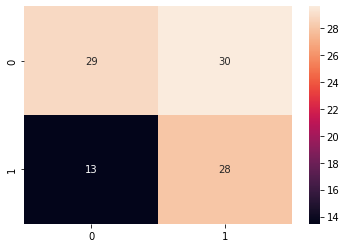

In [28]:
sns.heatmap(confusion_matrix(df_cont['FAKE_PORT_1'], df_cont['PREDICCION'])/len(df_cont)*100, annot=True)
plt.show()

In [29]:
df_cont['MC'] = np.where((df_cont['FAKE_PORT_1'] == 1) & (df_cont['PREDICCION'] == 1),
                         'TP', 
                         np.where((df_cont['FAKE_PORT_1'] == 0) & (df_cont['PREDICCION'] == 0), 
                                  'TN', 
                                  np.where((df_cont['FAKE_PORT_1'] == 1) & (df_cont['PREDICCION'] == 0), 
                                           'FN', 
                                           np.where((df_cont['FAKE_PORT_1'] == 0) & (df_cont['PREDICCION'] == 1), 
                                                    'FP', 
                                                    '0'))))

df_cont.groupby(['MC'])[['SUBSCRIBER_ID']].count()

,SUBSCRIBER_ID
MC,
FN,29960
FP,65973
TN,64249
TP,62408


In [31]:
df_cont = pd.merge(df_cont, gross[['SUBSCRIBER_ID', 'ESTADO', 'MES_BAJA', 'ULT_MOV', 'MES_BAJA']])

MergeError: Data columns not unique: Index(['SUBSCRIBER_ID', 'ESTADO', 'MES_BAJA', 'ULT_MOV'], dtype='object')

In [30]:
df_cont.query('MC == "FP"').groupby('ULT_MOV')[['SUBSCRIBER_ID']].count()

,SUBSCRIBER_ID
ULT_MOV,
GROSS ADDS MIGRACION,1
GROSS ADDS NUEVA,1
PERMANECE,65971


In [31]:
pd.DataFrame(df_cont.query('MC == "FP"')['ULT_MOV'].value_counts()/len(df_cont.query('MC == "FP"'))*100)

,ULT_MOV
PERMANECE,99.996968
GROSS ADDS NUEVA,0.001516
GROSS ADDS MIGRACION,0.001516


In [32]:
pd.crosstab(index=df_cont.query('MC == "FP"')['ULT_MOV'], columns=df_cont.query('MC == "FP"')['MES_BAJA'])

MES_BAJA,0
ULT_MOV,
GROSS ADDS MIGRACION,1
GROSS ADDS NUEVA,1
PERMANECE,65971


In [33]:
pd.DataFrame(round(df_cont.query('MC == "FP"').value_counts('MES_BAJA')/len(df_cont.query('MC == "FP"'))*100, 0))

,0
MES_BAJA,
0,100.0


In [34]:
df_cont.query('MC == "FP" & ULT_MOV == "PERMANECE"').groupby('ESTADO')[['SUBSCRIBER_ID']].count()

,SUBSCRIBER_ID
ESTADO,
Active,65190
Inactive,2
One-Way Block,763
Two-Way Block,16


In [37]:
pd.DataFrame(df_cont.query('MC == "FP" & ULT_MOV == "PERMANECE"')[['ESTADO']].value_counts()/len(df_cont.query('MC == "FP" & ULT_MOV == "PERMANECE"'))*1

SyntaxError: unexpected EOF while parsing (2757143987.py, line 1)

In [35]:
df_cont = pd.merge(df_cont, base_comp[['SUBSCRIBER_ID', 'ANT_MES', 'ULT_MES', 'ULT_MOV']], how='left')

In [36]:
df_cont.query('MC == "FP"').groupby(['ULT_MOV', 'ANT_MES'])[['SUBSCRIBER_ID']].count()

SUBSCRIBER_ID
ULT_MOV              ANT_MES                     
GROSS ADDS MIGRACION Termination                1
GROSS ADDS NUEVA     Termination                1
PERMANECE            Active                 65725
                     Inactive                   2
                     One-Way Block            228
                     Two-Way Block             16

In [37]:
pd.DataFrame(round(df_cont.query('MC == "FN"')['MES_BAJA'].value_counts()/len(df_cont.query('MC == "FN"'))*100))

,MES_BAJA
202209,59.0
202210,23.0
202208,18.0


In [38]:
pd.DataFrame(round(df_cont.query('MC == "FN"')['ULT_MOV'].value_counts()/len(df_cont.query('MC == "FN"'))*100))

,ULT_MOV
CHURN INACTIVIDAD,57.0
CHURN PORTACION,28.0
CHURN VOLUNTARIO,7.0
CHURN MIGRACION,7.0


In [39]:
pd.crosstab(index=df_cont.query('MC == "FN"')['ULT_MOV'], columns=df_cont.query('MC == "FN"')['MES_BAJA'])

MES_BAJA,202208,202209,202210
ULT_MOV,,,
CHURN INACTIVIDAD,0,13997,3229
CHURN MIGRACION,686,589,722
CHURN PORTACION,4653,2910,944
CHURN VOLUNTARIO,110,34,2086


In [40]:
round(df_cont.query('MC == "TP"')['ULT_MOV'].value_counts()/len(df_cont.query('MC == "TP"'))*100)

CHURN INACTIVIDAD    43.0
CHURN PORTACION      33.0
CHURN VOLUNTARIO     24.0
CHURN MIGRACION       1.0
CHURN FRAUDE          0.0
Name: ULT_MOV, dtype: float64

In [41]:
pd.crosstab(index=df_cont.query('MC == "TP"')['ULT_MOV'], columns=df_cont.query('MC == "TP"')['MES_BAJA'])

MES_BAJA,202208,202209,202210
ULT_MOV,,,
CHURN FRAUDE,0,0,1
CHURN INACTIVIDAD,1,2357,24168
CHURN MIGRACION,67,130,206
CHURN PORTACION,13139,4965,2535
CHURN VOLUNTARIO,27,21,14791


In [ ]:
#periodos proceso codigo para querys de los que se quedaron de calidad 
periodo=202201
periodo2=periodo+4

In [ ]:
#QUERY PARA LOS QUE SE HAN QUEDADO DE CADA MES 
query=f'''
SELECT * FROM (
SELECT  A.SUBSCRIBER_ID,
        B.PERIODO_PROCESO_CODIGO,
        B.MOVIMIENTO_TIPO_NOMBRE,
        ROW_NUMBER() OVER (PARTITION BY A.SUBSCRIBER_ID ORDER BY B.PERIODO_PROCESO_CODIGO DESC) AS RN
FROM AGG_DL_PJ_QUALITY A 
LEFT JOIN DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
WHERE   A.PERIODO_PROCESO_CODIGO='{periodo}'            
        AND B.SERVICIO='Prepaid'
        AND B.PERIODO_PROCESO_CODIGO<='{periodo2}'
) 
WHERE RN=1
'''

In [ ]:
#query que agrupa para sacar los 2 graficos 
query=f'''
SELECT  MOVIMIENTO_TIPO_NOMBRE,COUNT(*) FROM (
SELECT  A.SUBSCRIBER_ID,
        B.PERIODO_PROCESO_CODIGO,
        B.MOVIMIENTO_TIPO_NOMBRE,
        ROW_NUMBER() OVER (PARTITION BY A.SUBSCRIBER_ID ORDER BY B.PERIODO_PROCESO_CODIGO DESC) AS RN
FROM AGG_DL_PJ_QUALITY A 
LEFT JOIN DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
WHERE   A.PERIODO_PROCESO_CODIGO=202205            
        AND B.SERVICIO='Prepaid'
        AND B.PERIODO_PROCESO_CODIGO<=202209
) 
WHERE RN=1
GROUP BY MOVIMIENTO_TIPO_NOMBRE
'''

In [ ]:
query=f'''
SELECT  SEG_RFM,COUNT(*) FROM (
SELECT  A.SUBSCRIBER_ID,
        B.PERIODO_PROCESO_CODIGO,
        B.MOVIMIENTO_TIPO_NOMBRE,
        C.SEG_RFM,
        ROW_NUMBER() OVER (PARTITION BY A.SUBSCRIBER_ID ORDER BY B.PERIODO_PROCESO_CODIGO DESC) AS RN
FROM AGG_DL_PJ_QUALITY A 
LEFT JOIN DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING B ON A.SUBSCRIBER_ID=B.SUBSCRIBER_ID
LEFT JOIN MVALIENTE.TBL_ANL_BASE_PREPAGO C ON A.SUBSCRIBER_ID=C.SUBSCRIBER_ID
WHERE   A.PERIODO_PROCESO_CODIGO=202207            
        AND B.SERVICIO='Prepaid'
        AND B.PERIODO_PROCESO_CODIGO<=202211
) 
WHERE RN=1
GROUP BY SEG_RFM
'''

In [17]:
periodo=202206

In [36]:
#querys para mirar el comportamietno segun el ending del cada mes 

#query que da la base de usuarios de cierto mes DE GROSS
query=f'''
SELECT SUBSCRIBER_ID 
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
WHERE PERIODO_PROCESO_CODIGO='{periodo}'
      AND SERVICIO='Prepaid'
      AND MOVIMIENTO_TIPO_NOMBRE IN ('GROSS ADDS MIGRACION','GROSS ADDS NUEVA')
'''

In [9]:
#QUERY QUE AGRUPA A LOS QUE HICIERON GROSS
query=f'''
SELECT MOVIMIENTO_TIPO_NOMBRE,COUNT(*) AS TOTAL
FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
WHERE PERIODO_PROCESO_CODIGO='{periodo}'
      AND SERVICIO='Prepaid'
      AND MOVIMIENTO_TIPO_NOMBRE IN ('GROSS ADDS MIGRACION','GROSS ADDS NUEVA','GROSS ADDS PORTACION')
GROUP BY MOVIMIENTO_TIPO_NOMBRE
'''
base=cst.consulta(query)

c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [10]:
base['PORCENTAJE']=base['TOTAL']*100/base['TOTAL'].sum()

In [11]:
base

,MOVIMIENTO_TIPO_NOMBRE,TOTAL,PORCENTAJE
0,GROSS ADDS PORTACION,4924,2.696575
1,GROSS ADDS MIGRACION,5790,3.170831
2,GROSS ADDS NUEVA,171888,94.132594


In [12]:
#QUERY QUE DA LOS RESULTADOS por moviiento de los proximos meses del periodo de los gross ads nueva
for i in range(periodo,periodo+5):

    query=f'''
        SELECT MOVIMIENTO_TIPO_NOMBRE,COUNT(*) AS TOTAL
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE PERIODO_PROCESO_CODIGO='{i}'
        AND SERVICIO='Prepaid'
        AND SUBSCRIBER_ID IN (SELECT SUBSCRIBER_ID 
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE PERIODO_PROCESO_CODIGO='{periodo}'
        AND SERVICIO='Prepaid'
        AND MOVIMIENTO_TIPO_NOMBRE IN ('GROSS ADDS NUEVA'))
        GROUP BY MOVIMIENTO_TIPO_NOMBRE
        '''
    base=cst.consulta(query)
    print(periodo)
    print(i)
    print(base)


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202204
  MOVIMIENTO_TIPO_NOMBRE   TOTAL
0       GROSS ADDS NUEVA  171888


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202205
  MOVIMIENTO_TIPO_NOMBRE   TOTAL
0       CHURN VOLUNTARIO      48
1           CHURN FRAUDE       1
2        CHURN MIGRACION     620
3        CHURN PORTACION   13543
4      CHURN INACTIVIDAD      29
5              PERMANECE  157647


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202206
  MOVIMIENTO_TIPO_NOMBRE   TOTAL
0       CHURN VOLUNTARIO      61
1           CHURN FRAUDE       3
2        CHURN MIGRACION     428
3        CHURN PORTACION    5649
4   GROSS ADDS MIGRACION       6
5       GROSS ADDS NUEVA       1
6      CHURN INACTIVIDAD      25
7              PERMANECE  151481


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202207
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0       CHURN VOLUNTARIO     61
1        CHURN MIGRACION    313
2        CHURN PORTACION   2847
3   GROSS ADDS MIGRACION      7
4       GROSS ADDS NUEVA      3
5      CHURN INACTIVIDAD  53500
6              PERMANECE  94767


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202208
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0           CHURN FRAUDE      1
1       CHURN VOLUNTARIO    136
2    ACTIVACION NO GROSS     11
3        CHURN MIGRACION    371
4        CHURN PORTACION   1848
5   GROSS ADDS MIGRACION      6
6       GROSS ADDS NUEVA     57
7      CHURN INACTIVIDAD  21384
8              PERMANECE  71037


In [13]:
for i in range(periodo,periodo+5):

    query=f'''
        SELECT MOVIMIENTO_TIPO_NOMBRE,COUNT(*) AS TOTAL
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE PERIODO_PROCESO_CODIGO='{i}'
        AND SERVICIO='Prepaid'
        AND SUBSCRIBER_ID IN (SELECT SUBSCRIBER_ID 
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE PERIODO_PROCESO_CODIGO='{periodo}'
        AND SERVICIO='Prepaid'
        AND MOVIMIENTO_TIPO_NOMBRE IN ('GROSS ADDS MIGRACION'))
        GROUP BY MOVIMIENTO_TIPO_NOMBRE
        '''
    base=cst.consulta(query)
    print(periodo)
    print(i)
    print(base)


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202204
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0   GROSS ADDS MIGRACION   5790


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202205
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0       CHURN VOLUNTARIO     13
1        CHURN MIGRACION    176
2        CHURN PORTACION    525
3       GROSS ADDS NUEVA      2
4      CHURN INACTIVIDAD      4
5              PERMANECE   5070


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202206
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0       CHURN VOLUNTARIO     10
1        CHURN MIGRACION    100
2   GROSS ADDS MIGRACION      3
3        CHURN PORTACION    247
4      CHURN INACTIVIDAD      2
5              PERMANECE   4713


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202207
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0   GROSS ADDS PORTACION      3
1       CHURN VOLUNTARIO      3
2        CHURN MIGRACION     80
3   GROSS ADDS MIGRACION      8
4        CHURN PORTACION    153
5       GROSS ADDS NUEVA      2
6      CHURN INACTIVIDAD    122
7              PERMANECE   4358


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202208
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0   GROSS ADDS PORTACION      1
1       CHURN VOLUNTARIO     13
2    ACTIVACION NO GROSS      1
3        CHURN MIGRACION    106
4   GROSS ADDS MIGRACION     10
5        CHURN PORTACION    176
6      CHURN INACTIVIDAD     36
7              PERMANECE   4040


In [18]:
for i in range(periodo,periodo+5):

    query=f'''
        SELECT MOVIMIENTO_TIPO_NOMBRE,COUNT(*) AS TOTAL
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE PERIODO_PROCESO_CODIGO='{i}'
        AND SERVICIO='Prepaid'
        AND SUBSCRIBER_ID IN (SELECT SUBSCRIBER_ID 
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE PERIODO_PROCESO_CODIGO='{periodo}'
        AND SERVICIO='Prepaid'
        AND MOVIMIENTO_TIPO_NOMBRE IN ('GROSS ADDS PORTACION'))
        GROUP BY MOVIMIENTO_TIPO_NOMBRE
        '''
    base=cst.consulta(query)
    print(periodo)
    print(i)
    print(base)


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202206
202206
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0   GROSS ADDS PORTACION   5424


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202206
202207
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0       CHURN VOLUNTARIO     12
1        CHURN MIGRACION    135
2        CHURN PORTACION    256
3              PERMANECE   5021


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202206
202208
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0       CHURN VOLUNTARIO     12
1        CHURN MIGRACION     76
2   GROSS ADDS MIGRACION      2
3        CHURN PORTACION    216
4      CHURN INACTIVIDAD      1
5              PERMANECE   4716


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202206
202209
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0       CHURN VOLUNTARIO      8
1        CHURN MIGRACION    105
2   GROSS ADDS MIGRACION      6
3        CHURN PORTACION    154
4       GROSS ADDS NUEVA      2
5      CHURN INACTIVIDAD      8
6              PERMANECE   4443


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202206
202210
  MOVIMIENTO_TIPO_NOMBRE  TOTAL
0   GROSS ADDS PORTACION      1
1       CHURN VOLUNTARIO      6
2        CHURN MIGRACION    168
3   GROSS ADDS MIGRACION      5
4        CHURN PORTACION    110
5       GROSS ADDS NUEVA      2
6      CHURN INACTIVIDAD     24
7              PERMANECE   4143


In [44]:
#QUERY QUE DA LOS RESULTADOS por ESTADO de los proximos meses del periodo de los gross ads nueva
for i in range(periodo,periodo+5):

    query=f'''
        SELECT ESTADO,COUNT(*) AS TOTAL
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE PERIODO_PROCESO_CODIGO='{i}'
        AND SERVICIO='Prepaid'
        AND SUBSCRIBER_ID IN (SELECT SUBSCRIBER_ID 
        FROM DWH_BODEGA_WOM.FCT_SUBSCRIBERS_ENDING A 
        WHERE PERIODO_PROCESO_CODIGO='{periodo}'
        AND SERVICIO='Prepaid'
        AND MOVIMIENTO_TIPO_NOMBRE IN ('GROSS ADDS NUEVA'))
        GROUP BY ESTADO
        '''
    base=cst.consulta(query)
    print(periodo)
    print(i)
    print(base)


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202204
          ESTADO   TOTAL
0         Active  171562
1  One-Way Block     121
2  Two-Way Block     205


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202205
          ESTADO   TOTAL
0         Active  155390
1  One-Way Block    2216
2    Termination   14241
3  Two-Way Block      41


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202206
          ESTADO   TOTAL
0         Active  148695
1  One-Way Block    2751
2    Termination    6166
3  Two-Way Block      42


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202207
          ESTADO  TOTAL
0         Active  92975
1  One-Way Block   1764
2    Termination  56721
3  Two-Way Block     38


c:\Users\HP EliteBook 840 G3\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


202204
202208
          ESTADO  TOTAL
0         Active  61304
1  One-Way Block   9804
2    Termination  23740
3  Two-Way Block      3
